# install moabb & braindecode

In [ ]:
pip install moabb

In [ ]:
pip install braindecode

In [ ]:
pip install -U https://api.github.com/repos/shivar2/braindecode/zipball/master

  Using cached https://api.github.com/repos/shivar2/braindecode/zipball/master
  Created wheel for Braindecode: filename=Braindecode-0.5-cp37-none-any.whl size=67275 sha256=d21f73865df6303d4549ee870740a8a1c75cacd3dda3571fd840470879d18b1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-i__qwsgz/wheels/e8/96/7e/9b71798fc04d312683ade7e3a639b36579b720176c6a54dc86
Successfully built Braindecode
  Found existing installation: Braindecode 0.5
    Uninstalling Braindecode-0.5:
      Successfully uninstalled Braindecode-0.5


# connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, sys
os.chdir('/content/drive/MyDrive/MotorImagery-Classification')

# subject

In [ ]:
subject_id = 3

# load data

In [ ]:
import torch

dataset = torch.load('data-file/BNCI2014001/' + str(subject_id) + '.pt')

## Cut Compute Windows

for trials


In [ ]:
import numpy as np
from braindecode.datautil.windowers import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)


Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Loading data for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Loading data for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Loading data for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_

## Split dataset into train and valid

In [ ]:
splitted = windows_dataset.split('session')
train_set = splitted['session_T']
valid_set = splitted['session_E']

# Create model

In [ ]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import Deep4Net

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes=4
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

model = Deep4Net(
        in_chans=n_chans,
        n_classes=n_classes,
        input_window_samples=input_window_samples,
        n_filters_time=25,
        n_filters_spat=25,
        stride_before_pool=True,
        n_filters_2=int(n_chans * 2),
        n_filters_3=int(n_chans * (2 ** 2.0)),
        n_filters_4=int(n_chans * (2 ** 3.0)),
        final_conv_length='auto',
    )

# Send model to GPU
if cuda:
    model.cuda()


# Training

In [ ]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
# For deep4 they should be:
lr = 1 * 0.01
weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 50

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.2500        6.9481            0.2500      102.4721  0.0100  8.7769
      2            0.3090        4.3193            0.2361      120.8764  0.0100  6.1947
      3            0.2500        2.2574            0.2500       77.7363  0.0100  6.1723
      4            0.3333        1.9345            0.2535        6.5417  0.0099  6.2268
      5            0.2674        1.5607            0.2569        6.9064  0.0098  6.2097
      6            0.2674        1.3682            0.2604        7.2453  0.0097  6.2060
      7            0.3125        1.2213            0.2743        3.5445  0.0096  6.2385
      8            0.3611        1.2514            0.3125        3.6118  0.0095  6.1944
      9            0.5312        1.2049            0.4583        1.7306  0.0094  6.1617
     10            0.5868       

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=Deep4Net(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 25, kernel_size=(10, 1), stride=(1, 1))
    (conv_spat): Conv2d(25, 25, kernel_size=(1, 22), stride=(3, 1), bias=False)
    (bnorm): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin): Expression(expression=elu) 
    (pool): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (pool_nonlin): Expression(expression=identity) 
    (drop_2): Dropout(p=0.5, inplace=False)
    (conv_2): Conv2d(25, 44, kernel_size=(10, 1), stride=(3, 1), bias=False)
    (bnorm_2): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin_2): Expression(expression=elu) 
    (pool_2): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (pool_nonlin_2): Expressio

# Plot Results

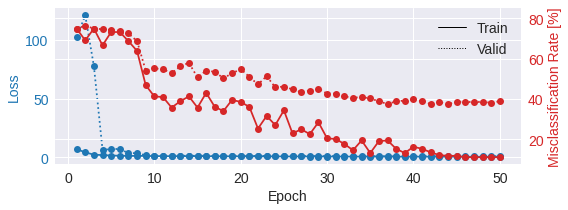

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()
